In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
import requests
import json
url = "https://raw.githubusercontent.com/duhaime/umap-zoo/03819ed0954b524919671a72f61a56032099ba11/data/json/bison.json"
animal = np.array(json.loads(requests.get(url).text)['3d'])
np.shape(animal)

(50000, 3)

In [6]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [7]:
animal = norm(animal)

In [8]:
np.min(animal, axis=0)

array([0.3590171 , 0.28384773, 0.        ])

(-0.051642771804062126,
 1.0516427718040622,
 0.25322656186139164,
 0.8763034951339842)

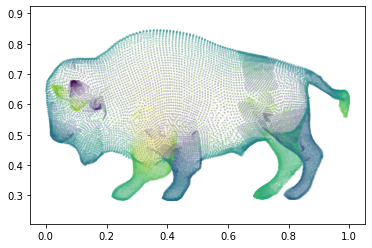

In [9]:
fig, ax = plt.subplots()
ax.scatter(animal[:,2], animal[:,1], s = 1, c = animal[:,0], alpha = 0.1)
ax.axis('equal')

In [10]:
X_train = animal
Y_train = animal[:, 2]
X_train_flat = X_train

### define networks

In [11]:
dims = (3)
n_components = 2

In [12]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(tf.keras.layers.Dense(units=100, activation="relu"))
encoder.add(
    tf.keras.layers.Dense(units=n_components, name="z")
)

In [13]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=3, activation="sigmoid"),
])

In [14]:
input_img = tf.keras.Input(dims)
output_img = decoder(encoder(input_img))
autoencoder = tf.keras.Model(input_img, output_img)

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [16]:
#X_train = X_train.reshape([len(X_train)] + list(dims))
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                #validation_data=(X_valid, X_valid)
                         )

Epoch 1/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6366
Epoch 2/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6210
Epoch 3/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6207
Epoch 4/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6205
Epoch 5/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6204
Epoch 6/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6202
Epoch 7/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6201
Epoch 8/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6199
Epoch 9/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6198
Epoch 10/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6197
Epoch 11/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6196
Epoch 12/50
196/196 [==============================] - 1s 3ms/step - loss: 0.6196
Epoch 13/50
196/196 [====

In [22]:
z = encoder.predict(X_train)

In [24]:
z_recon = decoder.predict(z)

### Plot model output

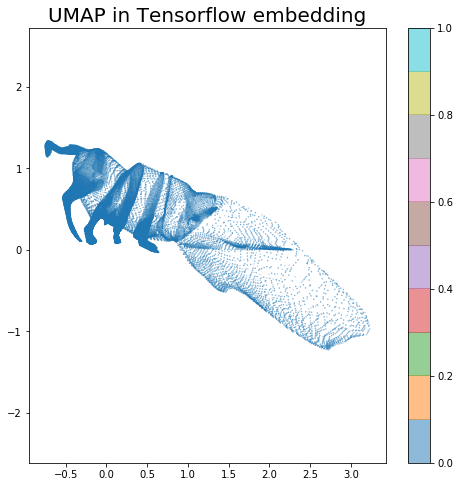

In [23]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)].flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

(-0.044518580281463875,
 1.035116185986725,
 0.2489653318747604,
 0.8682840377465165)

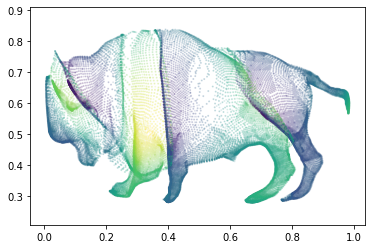

In [25]:
fig, ax = plt.subplots()
ax.scatter(z_recon[:,2], z_recon[:,1], s = 1, c = z_recon[:,0], alpha = 0.1)
ax.axis('equal')

### Save output

In [26]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [28]:
dataset = 'bison'

In [29]:
output_dir = MODEL_DIR/'projections'/ dataset / 'ae_only'
ensure_dir(output_dir)

In [30]:
encoder.save(output_dir / 'encoder')

W0822 11:25:17.440881 139825563027264 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
W0822 11:25:17.451968 139825563027264 deprecation.py:323] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
I0822 11:25:17.730912 139825563027264 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/bison/ae_only

In [31]:
decoder.save(output_dir / 'encoder')

I0822 11:25:18.719866 139825563027264 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/bison/ae_only/encoder/assets


In [32]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [33]:
np.save(output_dir / 'z.npy', z)